# ДЗ №7

Для запуска блокнота скачайте датасет и поместите его в директорию data.

Датасет:
https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings
import plotly.express as px

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [10]:
_data = pd.read_csv('data/Metro_Interstate_Traffic_Volume.csv', usecols=['traffic_volume', 'date_time', 'holiday', 'temp'])

## EDA

In [11]:
_data.head()

,holiday,temp,date_time,traffic_volume
0,NaN,288.28,2012-10-02 09:00:00,5545
1,NaN,289.36,2012-10-02 10:00:00,4516
2,NaN,289.58,2012-10-02 11:00:00,4767
3,NaN,290.13,2012-10-02 12:00:00,5026
4,NaN,291.14,2012-10-02 13:00:00,4918


In [12]:
_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   holiday         61 non-null     object 
 1   temp            48204 non-null  float64
 2   date_time       48204 non-null  object 
 3   traffic_volume  48204 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 1.5+ MB


In [13]:
_data.isna().any()

holiday            True
temp              False
date_time         False
traffic_volume    False
dtype: bool

Проверяем, есть ли дубликаты.

In [14]:
_data['date_time'].duplicated().any()

True

In [15]:
print('Удаление дубликатов.')
print('Количество записей до удаления: ', _data.shape[0])

_data.drop_duplicates(subset=['date_time'], inplace=True)

print('Количество записей после удаления: ', _data.shape[0])

Удаление дубликатов.
Количество записей до удаления:  48204
Количество записей после удаления:  40575


Кодируем категориальный признак. Это также позволит нам избавится от значений NaN в колонке holiday.

In [16]:
_data['holiday'] = LabelEncoder().fit_transform(_data['holiday'])

Выясняем тип колонки date_time.

In [17]:
type(_data['date_time'][0])

str

Меняем тип колонки date_time на datetime.

In [18]:
_data['date_time'] = pd.to_datetime(_data['date_time'])

In [19]:
_data.head()

,holiday,temp,date_time,traffic_volume
0,11,288.28,2012-10-02 09:00:00,5545
1,11,289.36,2012-10-02 10:00:00,4516
2,11,289.58,2012-10-02 11:00:00,4767
3,11,290.13,2012-10-02 12:00:00,5026
4,11,291.14,2012-10-02 13:00:00,4918


Значения date_time должны отстоять друг от друга на 1 час в соседних строчках. Проверим это.

In [20]:
_data['date_time'].diff().unique()

<TimedeltaArray>
[                NaT,   '0 days 01:00:00',   '0 days 02:00:00',
   '0 days 03:00:00',   '0 days 04:00:00',   '0 days 05:00:00',
   '0 days 08:00:00',   '0 days 09:00:00',   '0 days 07:00:00',
   '0 days 13:00:00',   '1 days 01:00:00',   '0 days 06:00:00',
   '0 days 14:00:00',   '1 days 23:00:00',   '1 days 06:00:00',
   '0 days 15:00:00',   '0 days 12:00:00',   '0 days 11:00:00',
   '0 days 22:00:00',   '1 days 00:00:00',   '0 days 17:00:00',
   '0 days 10:00:00',  '10 days 03:00:00',   '4 days 21:00:00',
   '0 days 21:00:00',   '2 days 17:00:00',   '1 days 09:00:00',
 '307 days 19:00:00',   '4 days 22:00:00',   '0 days 18:00:00',
   '1 days 10:00:00',   '3 days 21:00:00']
Length: 32, dtype: timedelta64[ns]

Поправим датасет таким образом, что бы выполнялось указанное выше условие.

In [21]:
_timestamps = pd.date_range('2012-10-02 09:00:00', '2018-09-30 23:00:00', freq='h').to_series(name='date_time')
_data = _data.merge(_timestamps, on='date_time', how='outer')
_data.interpolate(method='linear', inplace=True)

In [22]:
_data['date_time'].diff().unique()

<TimedeltaArray>
[NaT, '0 days 01:00:00']
Length: 2, dtype: timedelta64[ns]

## Моделирование

Разделим датасет на тренировочный и тестовый.

In [23]:
_test_size = 24 * 7 * 2

_train_data = _data.iloc[:_data.shape[0] - _test_size]
_test_data = _data.iloc[-_test_size:] # последние две недели

print('Размер тренировочного датасета:', _train_data.shape[0])
print('Размер тестового датасета:', _test_data.shape[0])

Размер тренировочного датасета: 52215
Размер тестового датасета: 336


Объявим утилиную функцию, которую будем использовать с разными моделями.

In [24]:
def make_forecast(model):
    train_size = len(_train_data)

    y_pred = model.predict(start=train_size, end=train_size + len(_test_data) - 1, dynamic=False)

    y_test = _test_data['traffic_volume']

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print(f'Mean Absolute Error: {mae:.2f}');
    print(f'Root Mean Squared Error: {rmse:.2f}')

    fig = plt.figure()
    fig.set_figheight(5)
    fig.set_figwidth(10)

    ax = fig.add_subplot()
    n = len(y_test)
    x = range(0, n)
    ax.plot(x, y_test)
    ax.plot(x, y_pred)

Визуализируем тестовые данные. Сгладим график при помощи скользящего среднего, что бы сделать его более читабельным.

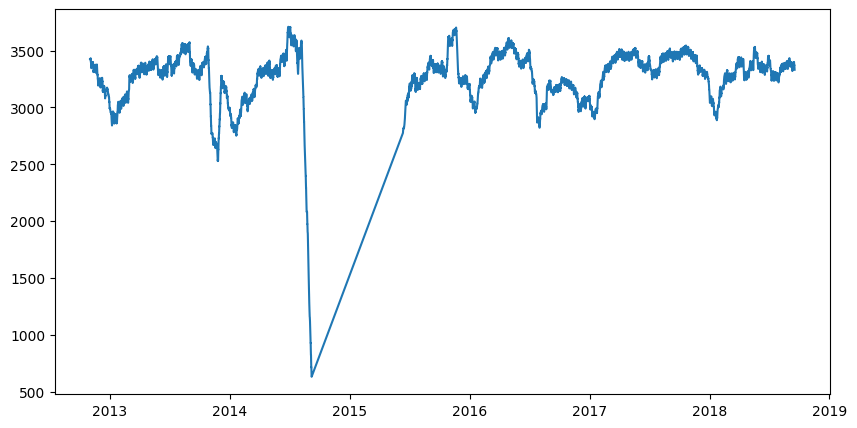

In [25]:
def calc_moving_avg(data):
    window_size = 30 * 24 # размер окна - 30 дней

    x = data['date_time']
    y = data['traffic_volume'].rolling(window_size).mean()

    fig = plt.figure()
    fig.set_figheight(5)
    fig.set_figwidth(10)

    ax = fig.add_subplot()
    ax.plot(x, y)


calc_moving_avg(_train_data)

[середина 2014, середина 2015] - похоже, данные за этот период отсутсвтуют.

Удалим все данные до начала 2016.

In [26]:
print('Количество записей до удаления:', _train_data.shape[0])

_mask = _train_data['date_time'] >= pd.to_datetime('2016-01-01')
_train_data = _train_data[_mask]

print('Количество записей после удаления:',_train_data.shape[0])

Количество записей до удаления: 52215
Количество записей после удаления: 23760


Визуализируем оставшиеся данные.

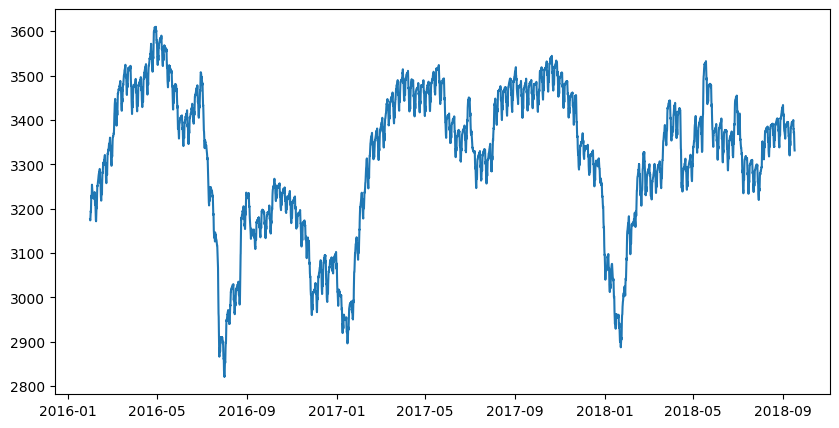

In [27]:
calc_moving_avg(_train_data)

Исследуем последние две недели.

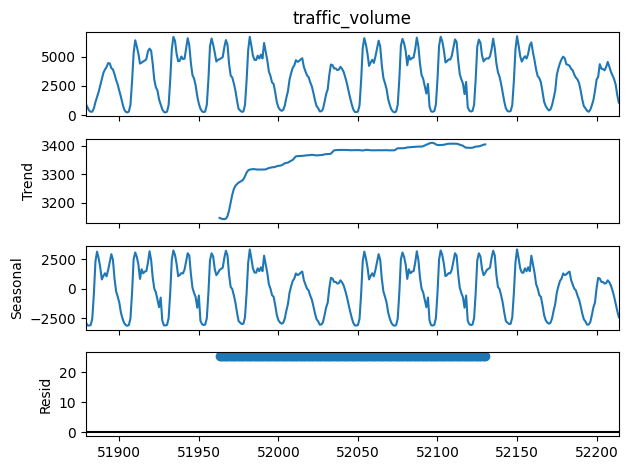

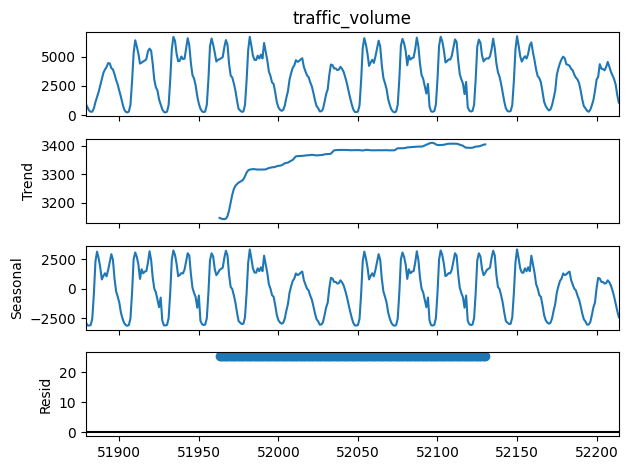

In [28]:
_last_two_weeks = _train_data['traffic_volume'][-24*7*2:]
seasonal_decompose(x=_last_two_weeks, model='additive', period = 24*7).plot()

Наблюдается четко выраженная сезонность. Восходящий тренд. Аддитивная модель.

### Baseline прогноз (средние значения по часам и дням)

Генерируем дополнительные признаки.

In [29]:
_train_data['hour'] = _train_data['date_time'].dt.hour
_train_data['weekday'] = _train_data['date_time'].dt.weekday

In [30]:
def make_baseline_forecast():
    # средние значения traffic_volume для каждого дня недели
    z = _train_data.groupby(['weekday', 'hour'])['traffic_volume'].mean()

    # удваиваем baseline потому что размер нашего тестового датасета - две недели
    y_pred = pd.concat([z] * 2, ignore_index=True).to_numpy()

    y_test = _test_data['traffic_volume']
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'Mean Absolute Error: {mae:.2f}');
    print(f'Root Mean Squared Error: {rmse:.2f}')

    fig = px.line(x=_test_data["date_time"], y=y_test, render_mode="svg", log_y=False)
    fig.add_scatter(x=_test_data["date_time"],  y=y_pred, mode='lines', name='Baseline')
    fig.show()


make_baseline_forecast()

Mean Absolute Error: 201.32
Root Mean Squared Error: 297.21


Теперь попробуем построить другие модели.

### AR-X

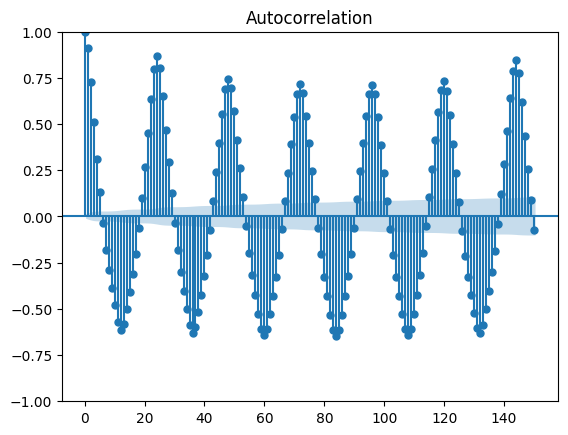

In [31]:
def acf():
    train_data = _train_data.copy()

    plot_acf(train_data['traffic_volume'], lags=150)
    plt.show()


acf()

In [32]:
def make_ar_forecast():
    y_train = _train_data['traffic_volume']
    y_test = _test_data['traffic_volume']
    x_test = _test_data['date_time']

    lags = range(1, 24*7*2)
    ar_model = AutoReg(y_train, lags=lags, trend='c').fit()

    y_pred = ar_model.predict(start=len(_train_data), end=len(_train_data) + len(_test_data) - 1, dynamic=False)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print(f'Mean Absolute Error: {mae:.2f}');
    print(f'Root Mean Squared Error: {rmse:.2f}');

    fig = px.line(x=x_test, y=y_test, render_mode="svg", log_y=False)
    fig.add_scatter(x=x_test,  y=y_pred, mode='lines', name='AR')
    fig.show()


make_ar_forecast()

Mean Absolute Error: 259.42
Root Mean Squared Error: 407.73


### ARIMA

Mean Absolute Error: 2523.16
Root Mean Squared Error: 3009.44


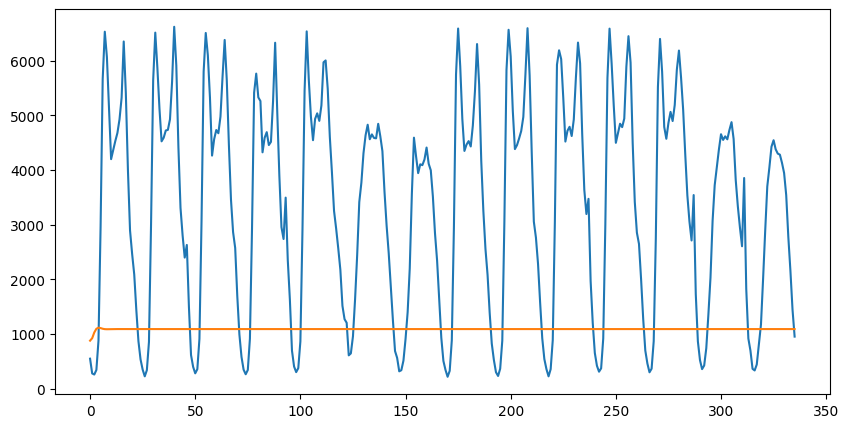

In [33]:
def make_arima_forecast():
    y_train = _train_data['traffic_volume']
    model = ARIMA(y_train, order=(2, 1, 0)).fit()
    make_forecast(model)


make_arima_forecast()

Как и следовало ожидать, результат плохой т.к. модель ARIMA не учитывает сезоннсть.

### SARIMA

In [51]:
_y_train = _train_data['traffic_volume']
_sarima_model = SARIMAX(_y_train, order=(2, 0, 0), seasonal_order=(2, 1, 0, 24*7)).fit(low_memory=True)

Mean Absolute Error: 221.51
Root Mean Squared Error: 384.79


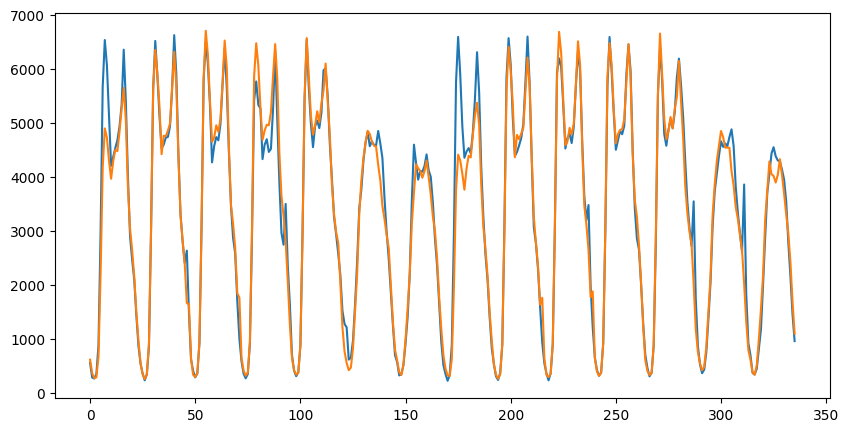

In [ ]:
make_forecast(_sarima_model)

In [26]:
_y_train = _train_data['traffic_volume']
_sarima_model2 = SARIMAX(_y_train, order=(2, 0, 0), seasonal_order=(2, 1, 1, 24*7)).fit(low_memory=True)

In [ ]:
make_forecast(_sarima_model2)

Лучше чем AR-X, но хуже чем baseline прогноз. Возможно, модель можно улучшить, указав ненулевые значения параметрам I(d) (т.к. в данных наблюдается тренд), а также MA(q) и сезонное MA(Q).

К сожалению модель обучается очень медленно, поэтому решено было ограничится параметрами, оказывающими наибольший эффект: AR(p) и сезонный I(D) (т.к. имеется ярко выраженный сезонный тренд).

## Выводы

В данной конкретной задаче, возможно, было бы достаточно простой модели на базе средних значений, либо AR-X модели.
Причина: требуется прогноз всего на неделю вперед. А значит, такую модель можно каждый раз быстро обучать заново по мере поступления новых данных.

Модель SARIMA имеет смысл, если из данных можно выделить цикличность и сезонность. Например: нагрузка метрополитена зимой и летом, в сезон отпусков и на празники. Однако для этого нужно иметь большую выборку. Кроме того, данные имеют свойство устаревать. К примеру, открыли новую станцию пересадки, новую ветку метро, новый маршрут наземного транспорта. Также возможны чрезвычайные ситуации, такие как пандемия. Обучить SARIMA сложнее, т.к. обучается медленно и требуется подбирать гиперпараметры.

Имеет смысл попробовать модель SARIMAX, т.к. она позволяет учитывать и другие признаки, например температуру воздуха. Однако целесообразность использования SARIMAX в данной задаче все равно под вопросом, т.к. обучить такую модель будет еще сложнее, а выгода по сравнению с простейшими моделями, скорее всего, будет небольшой.